# Time-varying volatility analysis

## Importing libraries

In [1]:
import sys
import os

# Data Manipulation
import pandas as pd
import pyreadr
import numpy as np
import matplotlib.pyplot as plt

# Convert to Datetime
from datetime import datetime


## Importing Payments data

### Loading data with non-market industries removed

In [2]:
bias_non_edu = False
bias_edu = False
non_market = True
subfolder = 'Saved_Data'
filename = 'Cleaned_Data_SIC5_non_market_removed.csv'
file_path = os.path.join(subfolder, filename)


dtype_mapping = {'from_pn': str, 'to_pn': str}

df_amt = pd.read_csv(file_path,dtype=dtype_mapping)


## Importing official GDP statistics

In the following we compare to different official GDP statistics. We compute time-varying volatility of GDP data

### Non-de-seasonalized GDP data

In [3]:
UK_GDP_non_season_df = pd.read_excel('/Users/jlumma/Documents/pluto_data/external_data/UK_GDP_non_season.xlsx', sheet_name='Monthly Index')


In [4]:
UK_GDP_non_season_df.columns = UK_GDP_non_season_df.iloc[3]

In [5]:
UK_GDP_non_season_df = UK_GDP_non_season_df.loc[4:][['Time period and dataset code row ','Total GVA ']]

In [6]:
UK_GDP_non_season_df['Total GVA '] = UK_GDP_non_season_df['Total GVA '].astype(float)

In [7]:
g_log_GDP_non_season = np.log(UK_GDP_non_season_df['Total GVA ']).T.diff(12).dropna().T


g_log_GDP_non_season = pd.concat([pd.DataFrame(g_log_GDP_non_season), UK_GDP_non_season_df['Time period and dataset code row ']], axis=1).dropna().copy()


In [8]:
cs_GDP_growth_time_series_seas = []



# The -1 is there because we could .diff() thus removing one column
for i in range(len(g_log_GDP_non_season)-11):
    cs_GDP_growth_time_series_seas.append(g_log_GDP_non_season['Total GVA '].T.iloc[i:i+12].std().T)

In [9]:
cs_GDP_growth_time_series_seas_df = pd.DataFrame(cs_GDP_growth_time_series_seas)

mean_GDP_seas = cs_GDP_growth_time_series_seas_df[0].mean()
std_GDP_seas = cs_GDP_growth_time_series_seas_df[0].std()
cs_GDP_growth_time_series_seas_df['Normalized_Value_agg_std'] = (cs_GDP_growth_time_series_seas_df[0] - mean_GDP_seas) / std_GDP_seas




###### Doing the Plot


Below we are creating the right Date column for the volatility time-series. Note that we used the a-priori prescription, i.e. we assign the variation of volatility between time t= $i$ and time = $i+11$ to time $i$

In [10]:
cs_GDP_growth_time_series_seas_df['Date'] = g_log_GDP_non_season.reset_index().iloc[:287-11].drop(columns = 'index')['Time period and dataset code row ']


In [11]:
cs_GDP_growth_time_series_seas_pluto_time_df = cs_GDP_growth_time_series_seas_df.iloc[96:164].copy()

In [12]:
cs_GDP_growth_time_series_seas_pluto_time_df = cs_GDP_growth_time_series_seas_df.iloc[216:].copy()

In [13]:
# Function to convert 'YYYYMMM' to 'YYYY-MM-DD'
def convert_to_datetime(date_str):
    return pd.to_datetime(date_str, format='%Y%b') + pd.offsets.MonthBegin(0)



In [14]:
cs_GDP_growth_time_series_seas_pluto_time_df = cs_GDP_growth_time_series_seas_pluto_time_df.set_index(cs_GDP_growth_time_series_seas_pluto_time_df['Date'].apply(convert_to_datetime))


In [15]:

mean_GDP_seas = cs_GDP_growth_time_series_seas_pluto_time_df[0].mean()
std_GDP_seas = cs_GDP_growth_time_series_seas_pluto_time_df[0].std()
cs_GDP_growth_time_series_seas_pluto_time_df['Normalized_Value_agg_std_pluto_time'] = (cs_GDP_growth_time_series_seas_pluto_time_df[0] - mean_GDP_seas) / std_GDP_seas




# Aggregate Volatility from Data

In [16]:
#### This function assumes a dataframe with two columns 'from_pn' and 'to_pn' corresponding to a production formalims framework,
#### where 'from_pn' refers to the supplier of goods and 'to_pn' to the buyer of goods.
#### It computes industry-level output or input depending on the direction variable. It also converts columns to datetime format
#### Moreover it also filters out rows in the dataframes that are not common to output and input 
##### (because certain industries might contain zero costs but not output in the dataset).

def compute_industry_levels(df, direction):
 
    if direction not in ['from_pn', 'to_pn']:
        raise ValueError("The direction parameter must be either 'from_pn' or 'to_pn'.")

    # Perform operations based on 'from_pn'    
    aggregate_output_SIC5 = df.drop(columns = 'to_pn').groupby(['from_pn']).sum()
    aggregate_output_SIC5 = aggregate_output_SIC5[(aggregate_output_SIC5 != 0).all(axis=1)]
     
        

    aggregate_input_SIC5 = df.drop(columns = 'from_pn').groupby(['to_pn']).sum()
    aggregate_input_SIC5 = aggregate_input_SIC5[(aggregate_input_SIC5 != 0).all(axis=1)]
    
    
    
    
    all_columns_contain_amt = all('_amt_' in col for col in df.drop(columns = ['from_pn','to_pn']).columns)
    
    if all_columns_contain_amt:
    #### Switching columns to datetime format
        aggregate_output_SIC5.columns = aggregate_output_SIC5.columns.str.replace('_amt_', '_')
        aggregate_output_SIC5.columns = pd.to_datetime(aggregate_output_SIC5.columns, format='%b_%y')

    
        aggregate_input_SIC5.columns = aggregate_input_SIC5.columns.str.replace('_amt_', '_')
        aggregate_input_SIC5.columns = pd.to_datetime(aggregate_input_SIC5.columns, format='%b_%y')
    
    
    
    common_indices = aggregate_input_SIC5.index.intersection(aggregate_output_SIC5.index)

# Filter both DataFrames to keep only the rows with common indices
    aggregate_input_SIC5 = aggregate_input_SIC5.loc[common_indices]
    aggregate_output_SIC5 = aggregate_output_SIC5.loc[common_indices]

    aggregate_input_SIC5.index.name = 'to_pn'
    aggregate_output_SIC5.index.name = 'from_pn'
   
    
    
    if direction == 'from_pn':
        return aggregate_output_SIC5
        
    elif direction == 'to_pn':
        return aggregate_input_SIC5
 
        

In [17]:
def compute_shares(df, direction):
    if direction not in ['from_pn', 'to_pn']:
        raise ValueError("The direction parameter must be either 'from_pn' or 'to_pn'.")

    shares = compute_industry_levels(df, direction)/compute_industry_levels(df, direction).sum()
    return shares

### Industries with zeros merged with other industries

In [18]:
aggregate_output_SIC5 = compute_industry_levels(df_amt, 'from_pn')

### Compute shares

In [19]:
outshares_SIC5 = aggregate_output_SIC5/aggregate_output_SIC5.sum()


In [20]:
outshares_SIC5_68_months = outshares_SIC5.T[12:80].T

## Industry-Level growth rates

In [21]:
g_log_SIC5 = (np.log(aggregate_output_SIC5)).T.diff(12).dropna().T

## Aggregate Output Growth

In [22]:
g_log_agg_season = np.log(aggregate_output_SIC5.sum()).T.diff(12).dropna().T

It is better to compute aggregate growth via a weighted sum of industry growth rates, i.e.
\begin{align}
 g_{agg,t} = \sum_i \omega_{it} g_{it}
\end{align}

In [23]:
g_log_agg_season = (outshares_SIC5.T.loc['2016-01-01':].T * g_log_SIC5).sum()

In [24]:
g_log_agg_season_df = pd.DataFrame(g_log_agg_season)

mean_agg_seas = g_log_agg_season_df[0].mean()
std_agg_seas = g_log_agg_season_df[0].std()
g_log_agg_season_df['Normalized_Value_g_log'] = (g_log_agg_season_df[0] - mean_agg_seas) / std_agg_seas




###### Time-varying volatility  of aggregate sales growth

In [25]:
cs_agg_growth_time_series_seas = []




# The -1 is there because we could .diff() thus removing one column
for i in range(len(g_log_agg_season.T.diff())-11):
    cs_agg_growth_time_series_seas.append(g_log_agg_season.T[i:i+12].std().T)

In [26]:
cs_agg_growth_time_series_seas_df = pd.DataFrame(cs_agg_growth_time_series_seas)

mean_agg_seas = cs_agg_growth_time_series_seas_df[0].mean()
std_agg_seas = cs_agg_growth_time_series_seas_df[0].std()
cs_agg_growth_time_series_seas_df['Normalized_Value_agg_std'] = (cs_agg_growth_time_series_seas_df[0] - mean_agg_seas) / std_agg_seas




The standard deviation of growth rates between time $t$ and time $t+12$ corresponds to the standard deviation at time $t$. Thus, while the time-series of year-on-year aggregate growth rates start in $2016-01-01$ and end in $2022-07-01$, the time-series of aggregate growth rates starts in $2016-01-01$ and ends in $2021-08-01$ (i.e. 68 months of datapoints).

In [27]:
# Setting dates as index. We take into account that the time-series of volatilities ends in 2021-08-01.
cs_agg_growth_time_series_seas_df.index = g_log_agg_season_df.index[0:68]

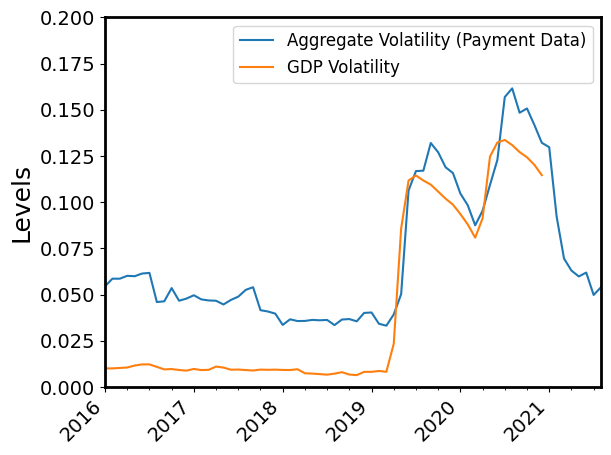

In [28]:
cs_agg_growth_time_series_seas_df[0].plot( label='Aggregate Volatility (Payment Data)')
cs_GDP_growth_time_series_seas_pluto_time_df[0].plot( label='GDP Volatility')



# Add labels and title
plt.ylabel('Levels',fontsize = 18)
plt.xlabel('',fontsize = 18)

# Increase the linewidth of the axes lines
ax = plt.gca()  # Get the current Axes instance
for spine in ax.spines.values():
    spine.set_linewidth(2)
    
# Increase the size of x-axis ticks
plt.xticks(fontsize=14)

# Increase the size of y-axis ticks
plt.yticks(fontsize=14)
plt.legend(fontsize = 12)
plt.ylim(0,0.2)
plt.xticks(rotation=45, ha='right')

plt.savefig('plots/correlation_GDP_volatility.png',bbox_inches='tight')



plt.show()

# Filtering the data

To estimate cost-shares we need to group by 'to_pn'. For sales-shares we need to group by 'from_pn'.

In [29]:
# Filter to keep rows where both 'from_pn' and 'to_pn' are in the set aggregate_output_SIC5.index
df_filtered = df_amt[
    df_amt['from_pn'].isin(aggregate_output_SIC5.index) &
    df_amt['to_pn'].isin(aggregate_output_SIC5.index)]


In [30]:
def compute_industry_shares(df_amt,direction):
    if direction == 'to_pn':
        dir_2 = 'from_pn'
    else:
        dir_2 = 'to_pn'
    ### We filter out the industries that have zero total output
    df_int = df_amt[
        df_amt['from_pn'].isin(aggregate_output_SIC5.index) &
        df_amt['to_pn'].isin(aggregate_output_SIC5.index)]

    
    
    df_filtered = df_int.groupby(['from_pn','to_pn']).sum().reset_index()
    
    int_df1 = pd.merge(df_filtered[[direction]].set_index(direction), df_filtered.drop(columns = dir_2).groupby(direction).sum(), left_index=True, right_index=True, how='inner')
    industry_shares = pd.DataFrame(df_filtered.drop(columns = ['from_pn','to_pn']).values/int_df1.values)
    
    industry_shares.columns = df_filtered.drop(columns = ['from_pn','to_pn']).columns


    industry_shares['from_pn'] = df_filtered['from_pn']
    industry_shares['to_pn'] = df_filtered['to_pn']

    return industry_shares


In [31]:
inshare_matrix = compute_industry_shares(df_amt,'to_pn')
outshare_matrix = compute_industry_shares(df_amt,'from_pn')

In [32]:
adj_matrix = []
# Create the weighted adjacency matrix
for col in inshare_matrix.drop(columns = ['from_pn','to_pn']).T.loc['jan_amt_16':].T.columns:
    adj_matrix_int = inshare_matrix.pivot(index='from_pn', columns='to_pn', values=col)

    # Fill NaN values with 0, since missing edges imply a weight of 0
    adj_matrix.append(adj_matrix_int.fillna(0))

In [33]:
eps_idio_int  = []
for i,date in enumerate(g_log_SIC5):
    eps_idio_int.append((pd.DataFrame(np.eye(len(g_log_SIC5))).values - 0.5*adj_matrix[i]).dot(g_log_SIC5[date]))
eps_idio = pd.concat(eps_idio_int, axis=1)
eps_idio.columns = g_log_SIC5.columns

# Comparing aggregate volatility computed from filtered and unfiltered growth rates

In [34]:
alpha = 0.5
L_matrix  = []
for i,date in enumerate(g_log_SIC5):
    L_matrix.append(pd.DataFrame(np.linalg.inv(pd.DataFrame(np.eye(len(g_log_SIC5))).values - alpha*adj_matrix[i])))


###### Computing time-varying covariance matrices for different approximations

Below we compute the time-series of covariance matrix for:
- unfiltered growth rates $g$
- filtered growth rates $\varepsilon$

In [35]:
cs_ind_cov_eps = []
cs_ind_cov_g_approx = []
cs_ind_cov_g = []

cs_ind_cov_eps.append(pd.DataFrame(eps_idio.T[0:12].cov().T))


# Approximation of reconstructed covariance matrix of growth rates with time-varying network and covariance matrix
cs_ind_cov_g_approx.append(pd.DataFrame((L_matrix[0].values.dot(cs_ind_cov_eps[0])).dot(L_matrix[0].T.values)))


# Exact covariance matrix of unfiltered growth rates
cs_ind_cov_g.append(pd.DataFrame(g_log_SIC5.T[0:12].cov().T))



# The -1 is there because we could .diff() thus removing one column
for i in range(len(eps_idio.T.diff())+1-13):
    cs_ind_cov_eps.append(pd.DataFrame(eps_idio.T[i+1:i+13].cov().T))
    cs_ind_cov_g_approx.append(pd.DataFrame((L_matrix[i+1].values.dot(cs_ind_cov_eps[i+1])).dot(L_matrix[i+1].T.values)))
    cs_ind_cov_g.append(pd.DataFrame(g_log_SIC5.T[i+1:i+13].cov().T))



Once the industry-by-industry covariance matrix for the different scenarios of interest have been obtained, we compute aggregate volatility by aggregating the covariance matrices with the sales-shares.

In [36]:
qty_g = []
qty_g_approx = []
time_2 = 0
for t_col in outshares_SIC5_68_months.columns:
    qty_g.append((((outshares_SIC5_68_months[t_col].values.dot(cs_ind_cov_g[time_2])).dot(outshares_SIC5_68_months[t_col].values)).sum().sum())**(0.5))
    qty_g_approx.append((((outshares_SIC5_68_months[t_col].values.dot(cs_ind_cov_g_approx[time_2])).dot(outshares_SIC5_68_months[t_col].values)).sum().sum())**(0.5))

    
    
    time_2 = time_2 + 1
                 
                 
                 

In [37]:
corr_fund_vol_g = pd.DataFrame(qty_g)
corr_fund_vol_g_approx = pd.DataFrame(qty_g_approx)

In [38]:
mean_corr_fund_seas = corr_fund_vol_g[0].mean()
std_corr_fund_seas = corr_fund_vol_g[0].std()
corr_fund_vol_g['Normalized_Value_sigma_fund'] = (corr_fund_vol_g[0] - mean_corr_fund_seas) / std_corr_fund_seas


In [39]:
mean_corr_fund_seas = corr_fund_vol_g_approx[0].mean()
std_corr_fund_seas = corr_fund_vol_g_approx[0].std()
corr_fund_vol_g_approx['Normalized_Value_sigma_fund'] = (corr_fund_vol_g_approx[0] - mean_corr_fund_seas) / std_corr_fund_seas


In [40]:
corr_fund_vol_g = corr_fund_vol_g.set_index(outshares_SIC5_68_months.columns)
corr_fund_vol_g_approx = corr_fund_vol_g_approx.set_index(outshares_SIC5_68_months.columns)

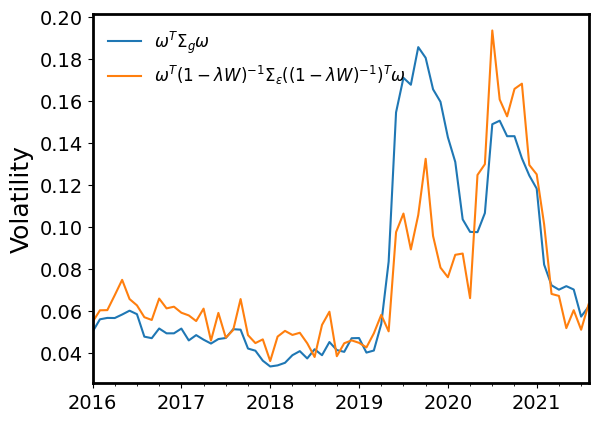

In [41]:
corr_fund_vol_g[0].plot(label = '$\omega^T \Sigma_g\omega$')
corr_fund_vol_g_approx[0].plot(label = '$\omega^T(1 - \lambda W)^{-1}\Sigma_\epsilon ((1 - \lambda W)^{-1})^T\omega$')

# Add labels and title
plt.ylabel('Volatility',fontsize = 18)
plt.xlabel('',fontsize = 18)

# Increase the linewidth of the axes lines
ax = plt.gca()  # Get the current Axes instance
for spine in ax.spines.values():
    spine.set_linewidth(2)
    
# Increase the size of x-axis ticks
plt.xticks(fontsize=14)

# Increase the size of y-axis ticks
plt.yticks(fontsize=14)
plt.legend(fontsize = 12,frameon =False)

plt.savefig('plots/volatility_filtered.png',bbox_inches='tight')

# Exploring different channels of contribution to aggregate volatility

Contributions to aggregate volatility come from a product of three terms, which are all time-varying. These three terms are
- sales-shares (outshares)
- the network/Leontief inverse
- the covariance matrix of filtered growth rates

In the following we are going to test in how changes in aggregate volatility is driven by changes in either of those quantities. To do so, we will compute aggregate volatility with different combinations of those channels having no time-dependence. The results are then shown visually in the form of six figures. Three of those figures show only one channel not being time-dependent (compared to the case where all 3 variables described above are time-varying) and the other three figures show the case where only one variable is time-dependent.

In [42]:
eps_times_w_df = eps_idio.T[:].T.mul(outshares_SIC5.T[12:].T).T.dropna().T

In [43]:
cs_ind_cov_eps_w = []
cs_ind_cov_eps_w.append(pd.DataFrame(eps_times_w_df.T[0:12].cov().T))
cs_ind_std_eps_w = pd.DataFrame(eps_times_w_df.T[0:12].std().T)

cs_ind_std_eps_w = cs_ind_std_eps_w.rename(columns = {0:13})



# The -1 is there because we could .diff() thus removing one column
for i in range(len(eps_times_w_df.T.diff())+1-13):
    cs_ind_std_eps_w[i+ 1 + 13] = pd.DataFrame(eps_times_w_df.T[i+1:i+13].std().T)
    cs_ind_cov_eps_w.append(pd.DataFrame(eps_times_w_df.T[i+1:i+13].cov().T))
    
    
    
    

In [44]:
cs_ind_cov_eps_w = []
cs_ind_cov_eps_w.append(pd.DataFrame(eps_times_w_df.T[0:12].cov().T))




# The -1 is there because we could .diff() thus removing one column
for i in range(len(eps_times_w_df.T.diff())+1-13):
    cs_ind_cov_eps_w.append(pd.DataFrame(eps_times_w_df.T[i+1:i+13].cov().T))

In [45]:
L_matrix  = []
for i,date in enumerate(g_log_SIC5):
    L_matrix.append(pd.DataFrame(np.linalg.inv(pd.DataFrame(np.eye(len(g_log_SIC5))).values - 0.5*adj_matrix[i])))

In [46]:
sum_matrix = np.sum(L_matrix, axis=0)

# Compute the average matrix
num_matrices = len(L_matrix)
L_matrix_avg = pd.DataFrame(sum_matrix / num_matrices)


#### Computing covariance matrices for the different combinations of not having time-dependence in at least one variable

In [47]:
cs_ind_cov_eps = [] # This one is useless




cs_ind_cov_g = [] # This is the aggregate covariance matrix (definetly correct)


cs_ind_cov_g_approx = []  # This is the reconstructed one using epsilon with time-varying network, the covariance is time-varying
cs_ind_cov_g_approx_no_time_L = [] #  This is the reconstructed one using epsilon but with fixed network, the covariance matrix is time-varying
cs_ind_cov_eps_w_approx = [] # This one is reconstructed with omega_t\cdot epsilon_t
cs_ind_cov_g_approx_no_time_cov = [] #  This is the reconstructed one using epsilon but with fixed network, the covariance matrix is time-varying
cs_ind_cov_g_approx_no_time_L_no_time_cov = [] # This is the reconstructed one using fixed network and fixed covariance





cs_ind_cov_eps.append(pd.DataFrame(eps_idio.T[0:12].cov().T))
cs_ind_std_eps = pd.DataFrame(eps_idio.T[0:12].std().T)

cs_ind_cov_g_approx.append(pd.DataFrame((L_matrix[0].values.dot(cs_ind_cov_eps[0])).dot(L_matrix[0].T.values)))
cs_ind_cov_g_approx_no_time_L.append(pd.DataFrame((L_matrix_avg.values.dot(cs_ind_cov_eps[0])).dot(L_matrix_avg.T.values)))
cs_ind_cov_g.append(pd.DataFrame(g_log_SIC5.T[0:12].cov().T))
cs_ind_cov_eps_w_approx.append(pd.DataFrame((L_matrix[0].values.dot(cs_ind_cov_eps_w[0])).dot(L_matrix[0].T.values)))


cs_ind_cov_g_approx_no_time_cov.append(pd.DataFrame((L_matrix[0].values.dot(pd.DataFrame(eps_idio.T.cov().T))).dot(L_matrix[0].T.values)))

cs_ind_cov_g_approx_no_time_L_no_time_cov.append(pd.DataFrame((L_matrix_avg.values.dot(pd.DataFrame(eps_idio.T.cov().T))).dot(L_matrix_avg.T.values)))
    
    
    

#cs_ind_cov = cs_ind_cov.rename(columns = {0:13})
cs_ind_std_eps = cs_ind_std_eps.rename(columns = {0:13})



# The -1 is there because we could .diff() thus removing one column
for i in range(len(eps_idio.T.diff())+1-13):
    cs_ind_std_eps[i+ 1 + 13] = pd.DataFrame(eps_idio.T[i+1:i+13].std().T)
    cs_ind_cov_eps.append(pd.DataFrame(eps_idio.T[i+1:i+13].cov().T))
    
    
    cs_ind_cov_g_approx.append(pd.DataFrame((L_matrix[i+1].values.dot(cs_ind_cov_eps[i+1])).dot(L_matrix[i+1].T.values)))
    cs_ind_cov_eps_w_approx.append(pd.DataFrame((L_matrix[i+1].values.dot(cs_ind_cov_eps_w[i+1])).dot(L_matrix[i+1].T.values)))
    cs_ind_cov_g.append(pd.DataFrame(g_log_SIC5.T[i+1:i+13].cov().T))
    cs_ind_cov_g_approx_no_time_L.append(pd.DataFrame((L_matrix_avg.values.dot(cs_ind_cov_eps[i])).dot(L_matrix_avg.T.values)))
    cs_ind_cov_g_approx_no_time_cov.append(pd.DataFrame((L_matrix[i+1].values.dot(pd.DataFrame(eps_idio.T.cov().T))).dot(L_matrix[i+1].T.values)))
    cs_ind_cov_g_approx_no_time_L_no_time_cov.append(pd.DataFrame((L_matrix_avg.values.dot(pd.DataFrame(eps_idio.T.cov().T))).dot(L_matrix_avg.T.values)))

    
    
    

###### Aggregating the covariance matrices with the sales shares

In [48]:
qty_g = []
qty_eps_approx = []
qty_eps_approx_no_time_shares  =[]
qty_eps_approx_no_time_L = []
qty_eps_approx_no_time_L_no_time_shares = []

qty_eps_approx_no_time_cov = []
qty_eps_approx_no_time_cov_no_time_shares = []
qty_eps_approx_no_time_L_no_time_cov = []
qty_eps_approx_no_time_L_no_time_cov_no_time_shares = []


cs_ind_cov_g_approx_no_time_cov
cs_ind_cov_g_approx_no_time_L_no_time_cov


time_2 = 0
for t_col in outshares_SIC5_68_months.columns:
    qty_g.append((((outshares_SIC5_68_months[t_col].values.dot(cs_ind_cov_g[time_2])).dot(outshares_SIC5_68_months[t_col].values)).sum().sum())**(0.5))
    qty_eps_approx.append((((outshares_SIC5_68_months[t_col].values.dot(cs_ind_cov_g_approx[time_2])).dot(outshares_SIC5_68_months[t_col].values)).sum().sum())**(0.5))
    
    qty_eps_approx_no_time_shares.append((((outshares_SIC5_68_months['2016-01-01'].values.dot(cs_ind_cov_g_approx[time_2])).dot(outshares_SIC5_68_months['2016-01-01'].values)).sum().sum())**(0.5))

    
    
    qty_eps_approx_no_time_L.append((((outshares_SIC5_68_months[t_col].values.dot(cs_ind_cov_g_approx_no_time_L[time_2])).dot(outshares_SIC5_68_months[t_col].values)).sum().sum())**(0.5))
    
    qty_eps_approx_no_time_L_no_time_shares.append((((outshares_SIC5_68_months['2016-01-01'].values.dot(cs_ind_cov_g_approx_no_time_L[time_2])).dot(outshares_SIC5_68_months['2016-01-01'].values)).sum().sum())**(0.5))

    
    qty_eps_approx_no_time_cov.append((((outshares_SIC5_68_months[t_col].values.dot(cs_ind_cov_g_approx_no_time_cov[time_2])).dot(outshares_SIC5_68_months[t_col].values)).sum().sum())**(0.5))
    qty_eps_approx_no_time_cov_no_time_shares.append((((outshares_SIC5_68_months['2016-01-01'].values.dot(cs_ind_cov_g_approx_no_time_cov[time_2])).dot(outshares_SIC5_68_months['2016-01-01'].values)).sum().sum())**(0.5))
    qty_eps_approx_no_time_L_no_time_cov_no_time_shares.append((((outshares_SIC5_68_months['2016-01-01'].values.dot(cs_ind_cov_g_approx_no_time_L_no_time_cov[time_2])).dot(outshares_SIC5_68_months['2016-01-01'].values)).sum().sum())**(0.5))
    
    
    qty_eps_approx_no_time_L_no_time_cov.append((((outshares_SIC5_68_months[t_col].values.dot(cs_ind_cov_g_approx_no_time_L_no_time_cov[time_2])).dot(outshares_SIC5_68_months[t_col].values)).sum().sum())**(0.5))

    time_2 = time_2 + 1
                 
                 
                 

###### Converting to dataframes

In [50]:
corr_fund_vol_g = pd.DataFrame(qty_g)
corr_fund_vol_eps_approx = pd.DataFrame(qty_eps_approx)
corr_fund_vol_eps_approx_no_time_L = pd.DataFrame(qty_eps_approx_no_time_L)
corr_fund_vol_eps_approx_no_time_L_no_shares = pd.DataFrame(qty_eps_approx_no_time_L_no_time_shares)

corr_fun_vol_eps_approx_no_time_shares = pd.DataFrame(qty_eps_approx_no_time_shares)


corr_fund_vol_eps_approx_no_time_cov  = pd.DataFrame(qty_eps_approx_no_time_cov)
corr_fund_vol_eps_approx_no_time_cov_no_time_shares = pd.DataFrame(qty_eps_approx_no_time_cov_no_time_shares)
corr_fund_vol_eps_approx_no_time_L_no_time_cov_no_time_shares  = pd.DataFrame(qty_eps_approx_no_time_L_no_time_cov_no_time_shares)
corr_fund_vol_eps_approx_no_time_L_no_time_cov = pd.DataFrame(qty_eps_approx_no_time_L_no_time_cov)


###### Setting Datetime as Index

In [51]:
corr_fund_vol_eps_approx_no_time_L = corr_fund_vol_eps_approx_no_time_L.set_index(outshares_SIC5_68_months.columns)

corr_fund_vol_eps_approx_no_time_L_no_shares = corr_fund_vol_eps_approx_no_time_L_no_shares.set_index(outshares_SIC5_68_months.columns)
corr_fund_vol_eps_approx_no_time_cov = corr_fund_vol_eps_approx_no_time_cov.set_index(outshares_SIC5_68_months.columns)
corr_fund_vol_eps_approx_no_time_cov = corr_fund_vol_eps_approx_no_time_cov.set_index(outshares_SIC5_68_months.columns)
corr_fund_vol_eps_approx_no_time_L_no_time_cov_no_time_shares = corr_fund_vol_eps_approx_no_time_L_no_time_cov_no_time_shares.set_index(outshares_SIC5_68_months.columns)
corr_fund_vol_eps_approx_no_time_L_no_time_cov = corr_fund_vol_eps_approx_no_time_L_no_time_cov.set_index(outshares_SIC5_68_months.columns)
corr_fun_vol_eps_approx_no_time_shares = corr_fun_vol_eps_approx_no_time_shares.set_index(outshares_SIC5_68_months.columns)
corr_fund_vol_eps_approx_no_time_cov_no_time_shares = corr_fund_vol_eps_approx_no_time_cov_no_time_shares.set_index(outshares_SIC5_68_months.columns)


corr_fund_vol_g = corr_fund_vol_g.set_index(outshares_SIC5_68_months.columns)
corr_fund_vol_eps_approx = corr_fund_vol_eps_approx.set_index(outshares_SIC5_68_months.columns)


In [52]:
g_times_w_df = g_log_SIC5.T[:].T.mul(outshares_SIC5.T[12:].T).T.dropna().T

In [53]:
cs_ind_cov_g_w = []
cs_ind_cov_g_w.append(pd.DataFrame(g_times_w_df.T[0:12].cov().T))
cs_ind_std_g_w = pd.DataFrame(g_times_w_df.T[0:12].std().T)

cs_ind_std_g_w = cs_ind_std_g_w.rename(columns = {0:13})



# The -1 is there because we could .diff() thus removing one column
for i in range(len(g_times_w_df.T.diff())+1-13):
    cs_ind_std_g_w[i+ 1 + 13] = pd.DataFrame(g_times_w_df.T[i+1:i+13].std().T)
    cs_ind_cov_g_w.append(pd.DataFrame(g_times_w_df.T[i+1:i+13].cov().T))
    
    
    
    

In [54]:
cs_ind_std_g_w.columns = outshares_SIC5_68_months.columns

### Computing covariance matrices

In [55]:
cs_ind_cov_g_w = []
cs_ind_cov_g_w.append(pd.DataFrame(g_times_w_df.T[0:12].cov().T))


# The -1 is there because we could .diff() thus removing one column
for i in range(len(g_times_w_df.T.diff())+1-13):
    cs_ind_cov_g_w.append(pd.DataFrame(g_times_w_df.T[i+1:i+13].cov().T))

In [56]:
size = len(cs_ind_cov_g_w[0])
row_vector = np.ones(size).reshape(1, -1)

# Create a column vector of ones
column_vector = np.ones(size).reshape(-1, 1)


In [57]:
qty_g_w = []

time_2 = 0
for t_col in outshares_SIC5_68_months.columns:
    qty_g_w.append((((row_vector.dot(cs_ind_cov_g_w[time_2])).dot(column_vector)).sum().sum())**(0.5))
    time_2 = time_2 + 1
                 
                 
                 

In [58]:
corr_fund_g_w = pd.DataFrame(qty_g_w)

In [59]:
corr_fund_g_w = corr_fund_g_w.set_index(outshares_SIC5_68_months.columns)

In [60]:
mean_corr_fund_seas = corr_fund_g_w[0].mean()
std_corr_fund_seas = corr_fund_g_w[0].std()
corr_fund_g_w['Normalized_Value_sigma_fund'] = (corr_fund_g_w[0] - mean_corr_fund_seas) / std_corr_fund_seas


In [61]:
cs_agg_growth_68_months_df = pd.DataFrame(cs_agg_growth_time_series_seas_df.iloc[:][0])

In [62]:

mean_GDP_seas = cs_agg_growth_68_months_df[0].mean()
std_GDP_seas = cs_agg_growth_68_months_df[0].std()
cs_agg_growth_68_months_df['Normalized_Value_agg_std'] = (cs_agg_growth_68_months_df[0] - mean_GDP_seas) / std_GDP_seas




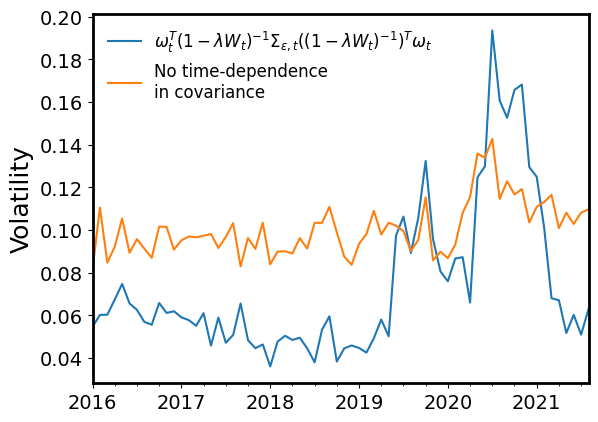

In [63]:
corr_fund_vol_eps_approx[0].plot(label = '$\omega_t^T(1 - \lambda W_t)^{-1}\Sigma_{\epsilon,t} ((1 - \lambda W_t)^{-1})^T\omega_t$')
corr_fund_vol_eps_approx_no_time_cov[0].plot(label = 'No time-dependence\nin covariance')


# Add labels and title
plt.ylabel('Volatility',fontsize = 18)
plt.xlabel('',fontsize = 18)

# Increase the linewidth of the axes lines
ax = plt.gca()  # Get the current Axes instance
for spine in ax.spines.values():
    spine.set_linewidth(2)
    
# Increase the size of x-axis ticks
plt.xticks(fontsize=14)

# Increase the size of y-axis ticks
plt.yticks(fontsize=14)
plt.legend(fontsize = 12,frameon =False)

plt.savefig('plots/vol_decomp/volatility_no_time_cov.png',bbox_inches='tight')

plt.show()

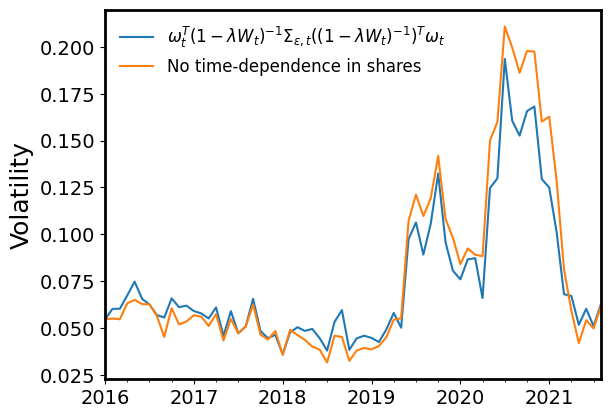

In [64]:
corr_fund_vol_eps_approx[0].plot(label = '$\omega_t^T(1 - \lambda W_t)^{-1}\Sigma_{\epsilon,t} ((1 - \lambda W_t)^{-1})^T\omega_t$')
corr_fun_vol_eps_approx_no_time_shares[0].plot(label = 'No time-dependence in shares')

# Add labels and title
plt.ylabel('Volatility',fontsize = 18)
plt.xlabel('',fontsize = 18)

# Increase the linewidth of the axes lines
ax = plt.gca()  # Get the current Axes instance
for spine in ax.spines.values():
    spine.set_linewidth(2)
    
# Increase the size of x-axis ticks
plt.xticks(fontsize=14)

# Increase the size of y-axis ticks
plt.yticks(fontsize=14)
plt.legend(fontsize = 12,frameon =False)

plt.savefig('plots/vol_decomp/volatility_no_time_shares.png',bbox_inches='tight')

plt.show()


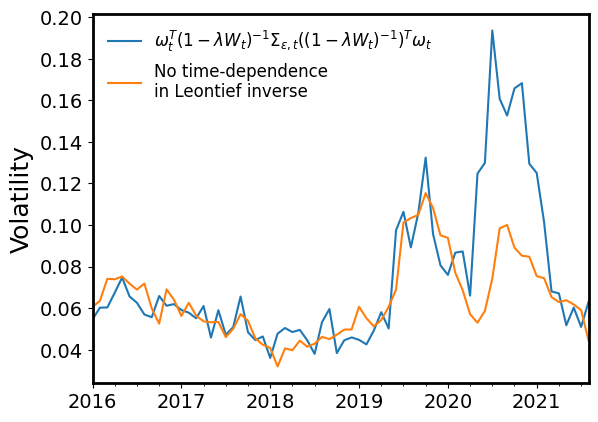

In [65]:
corr_fund_vol_eps_approx[0].plot(label = '$\omega_t^T(1 - \lambda W_t)^{-1}\Sigma_{\epsilon,t} ((1 - \lambda W_t)^{-1})^T\omega_t$')

corr_fund_vol_eps_approx_no_time_L[0].plot(label = 'No time-dependence\nin Leontief inverse')


# Add labels and title
plt.ylabel('Volatility',fontsize = 18)
plt.xlabel('',fontsize = 18)

# Increase the linewidth of the axes lines
ax = plt.gca()  # Get the current Axes instance
for spine in ax.spines.values():
    spine.set_linewidth(2)
    
# Increase the size of x-axis ticks
plt.xticks(fontsize=14)

# Increase the size of y-axis ticks
plt.yticks(fontsize=14)
plt.legend(fontsize = 12,frameon =False)

plt.savefig('plots/vol_decomp/volatility_no_time_L.png',bbox_inches='tight')

plt.show()

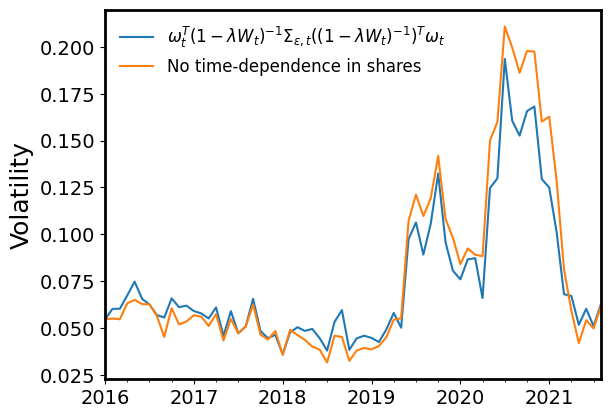

In [66]:
corr_fund_vol_eps_approx[0].plot(label = '$\omega_t^T(1 - \lambda W_t)^{-1}\Sigma_{\epsilon,t} ((1 - \lambda W_t)^{-1})^T\omega_t$')
corr_fun_vol_eps_approx_no_time_shares[0].plot(label = 'No time-dependence in shares')


# Add labels and title
plt.ylabel('Volatility',fontsize = 18)
plt.xlabel('',fontsize = 18)

# Increase the linewidth of the axes lines
ax = plt.gca()  # Get the current Axes instance
for spine in ax.spines.values():
    spine.set_linewidth(2)
    
# Increase the size of x-axis ticks
plt.xticks(fontsize=14)

# Increase the size of y-axis ticks
plt.yticks(fontsize=14)
plt.legend(fontsize = 12,frameon =False)

plt.savefig('plots/vol_decomp/volatility_no_time_shares.png',bbox_inches='tight')

plt.show()

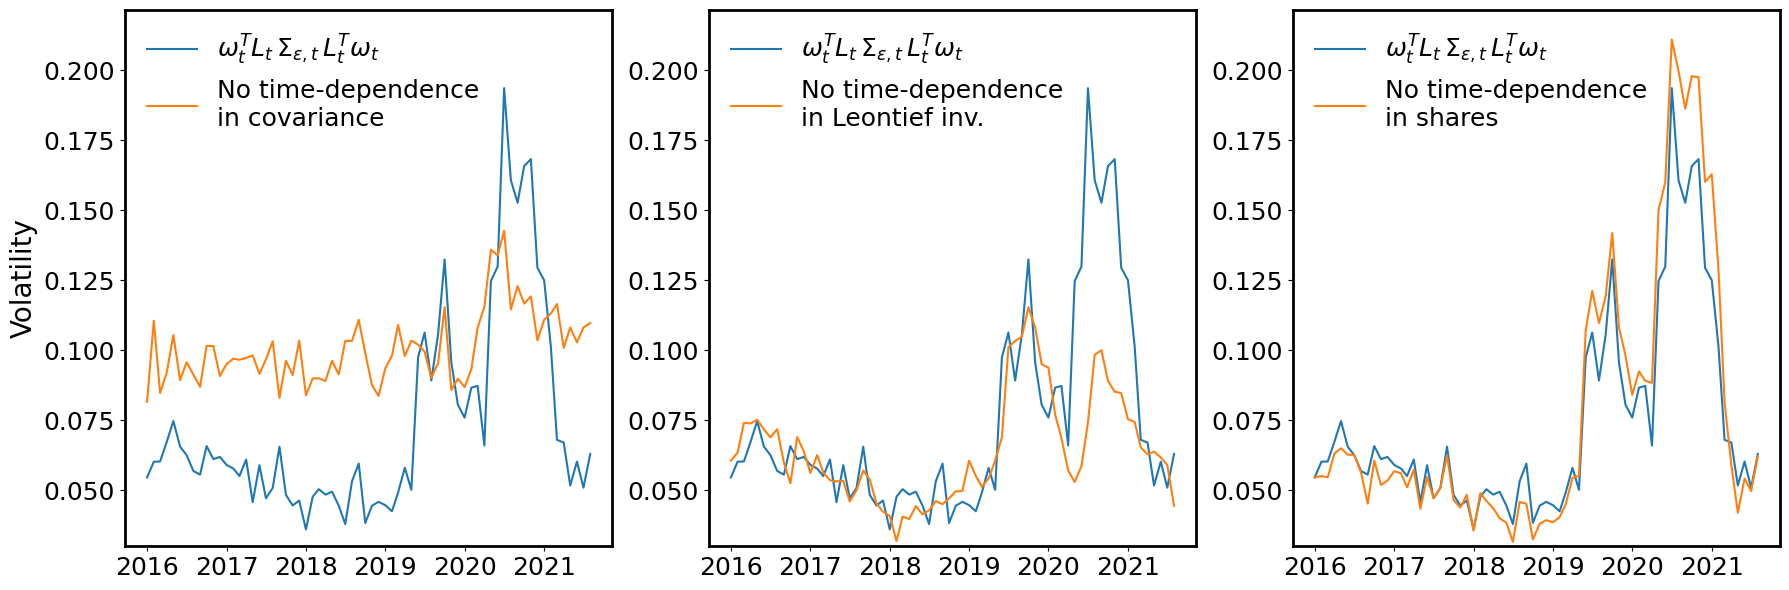

In [67]:
# Create a figure and a set of subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 6))




# Calculate the overall min and max y-values for consistent y-axis scaling
min_y = min(
    corr_fund_vol_eps_approx[0].min(), 
    corr_fund_vol_eps_approx_no_time_cov[0].min(),
    corr_fund_vol_eps_approx_no_time_L[0].min(),corr_fun_vol_eps_approx_no_time_shares[0].min()
)
max_y = max(
    corr_fund_vol_eps_approx[0].max(), 
    corr_fund_vol_eps_approx_no_time_cov[0].max(),
    corr_fund_vol_eps_approx_no_time_L[0].max(),corr_fun_vol_eps_approx_no_time_shares[0].max()
)

min_y  = 0.95*min_y
max_y  = 1.05*max_y




axs[0].plot(corr_fund_vol_eps_approx[0], label='$\omega_t^TL_t\,\Sigma_{\epsilon,t} \,L_t^T\omega_t$')
axs[0].plot(corr_fund_vol_eps_approx_no_time_cov[0],label = 'No time-dependence\nin covariance')

axs[0].set_ylabel('Volatility', fontsize=20)
axs[0].set_xlabel('', fontsize=20)
axs[0].legend(fontsize=18, frameon=False,loc='upper left')
axs[0].set_ylim(min_y, max_y)


# Plot data on the second subplot
axs[1].plot(corr_fund_vol_eps_approx[0], label='$\omega_t^TL_t\,\Sigma_{\epsilon,t} \,L_t^T\omega_t$')

axs[1].plot(corr_fund_vol_eps_approx_no_time_L[0],label = 'No time-dependence\nin Leontief inv.')


axs[1].set_xlabel('', fontsize=18)
axs[1].legend(fontsize=18, frameon=False,loc='upper left')
axs[1].set_ylim(min_y, max_y)




# Plot data on the third subplot
axs[2].plot(corr_fund_vol_eps_approx[0],label='$\omega_t^TL_t\,\Sigma_{\epsilon,t} \,L_t^T\omega_t$')
axs[2].plot(corr_fun_vol_eps_approx_no_time_shares[0],label = 'No time-dependence\nin shares')



axs[2].set_xlabel('', fontsize=18)
axs[2].legend(fontsize=18, frameon=False)
axs[2].set_ylim(min_y, max_y)


# Customize the axes for each subplot
for ax in axs:
    # Increase the linewidth of the axes lines
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    # Increase the size of x-axis and y-axis ticks
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

# Adjust the layout
plt.tight_layout()

# Save the figure
plt.savefig('plots/vol_decomp/volatility_no_time_variables.pdf', bbox_inches='tight')

# Show the plot
plt.show()


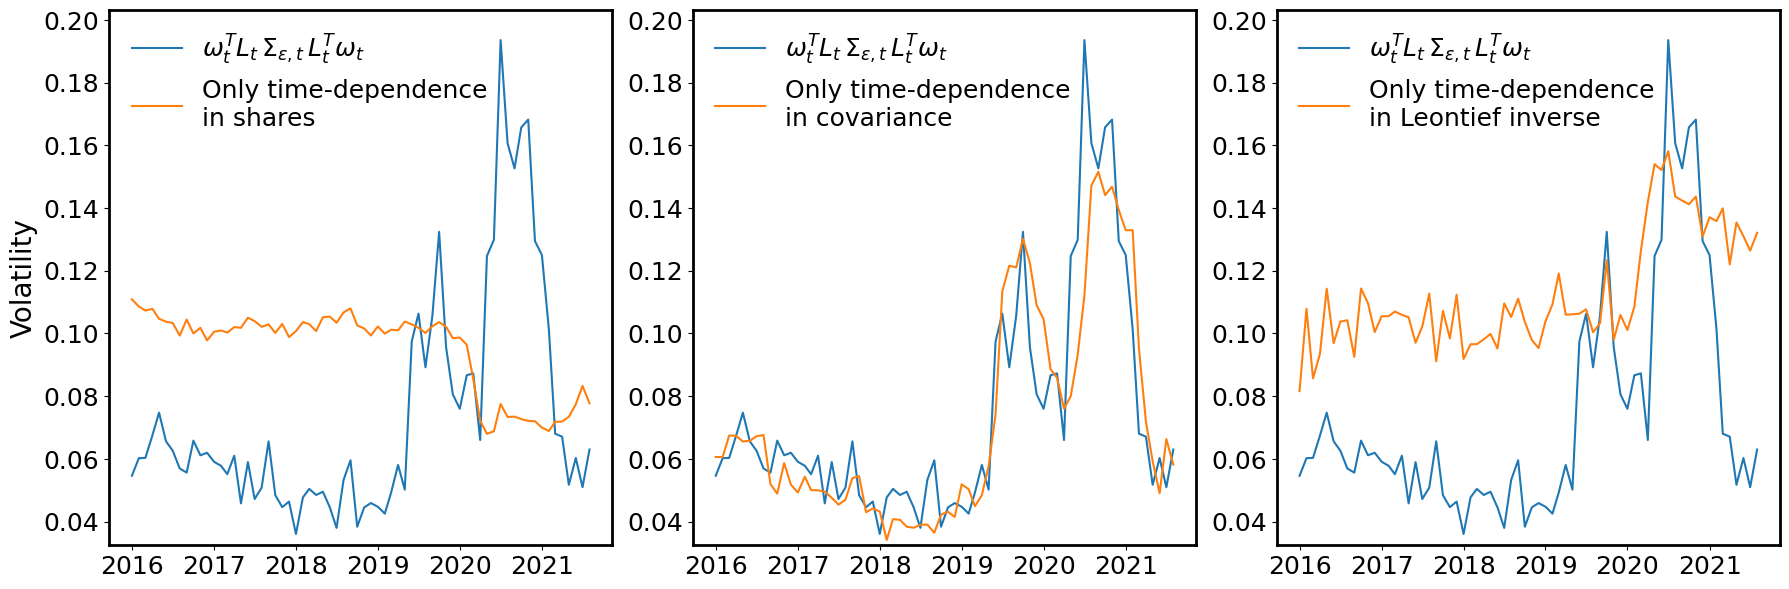

In [68]:
# Create a figure and a set of subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot data on the first subplot



# Calculate the overall min and max y-values for consistent y-axis scaling
min_y = min(
    corr_fund_vol_eps_approx[0].min(), 
    corr_fund_vol_eps_approx_no_time_L_no_time_cov[0].min(),
    corr_fund_vol_eps_approx_no_time_L_no_shares[0].min(),corr_fund_vol_eps_approx_no_time_cov_no_time_shares[0].min()
)
max_y = max(
    corr_fund_vol_eps_approx[0].max(), 
    corr_fund_vol_eps_approx_no_time_L_no_time_cov[0].max(),
    corr_fund_vol_eps_approx_no_time_L_no_shares[0].max(),corr_fund_vol_eps_approx_no_time_cov_no_time_shares[0].max()
)

min_y  = 0.95*min_y
max_y  = 1.05*max_y




axs[0].plot(corr_fund_vol_eps_approx[0], label='$\omega_t^TL_t\,\Sigma_{\epsilon,t} \,L_t^T\omega_t$')
axs[0].plot(corr_fund_vol_eps_approx_no_time_L_no_time_cov[0],label = 'Only time-dependence\nin shares')

axs[0].set_ylabel('Volatility', fontsize=20)
axs[0].set_xlabel('', fontsize=20)
axs[0].legend(fontsize=18, frameon=False,loc='upper left')
axs[0].set_ylim(min_y, max_y)


# Plot data on the second subplot
axs[1].plot(corr_fund_vol_eps_approx[0], label='$\omega_t^TL_t\,\Sigma_{\epsilon,t} \,L_t^T\omega_t$')

axs[1].plot(corr_fund_vol_eps_approx_no_time_L_no_shares[0],label = 'Only time-dependence\nin covariance')


axs[1].set_xlabel('', fontsize=18)
axs[1].legend(fontsize=18, frameon=False,loc='upper left')
axs[1].set_ylim(min_y, max_y)




# Plot data on the third subplot
axs[2].plot(corr_fund_vol_eps_approx[0],label='$\omega_t^TL_t\,\Sigma_{\epsilon,t} \,L_t^T\omega_t$')
axs[2].plot(corr_fund_vol_eps_approx_no_time_cov_no_time_shares[0],label = 'Only time-dependence\nin Leontief inverse')



#axs[2].set_ylabel('Volatility', fontsize=18)
axs[2].set_xlabel('', fontsize=18)
axs[2].legend(fontsize=18, frameon=False)
axs[2].set_ylim(min_y, max_y)


# Customize the axes for each subplot
for ax in axs:
    # Increase the linewidth of the axes lines
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    # Increase the size of x-axis and y-axis ticks
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

# Adjust the layout
plt.tight_layout()

# Save the figure
plt.savefig('plots/vol_decomp/volatility_no_time_two_variables.pdf', bbox_inches='tight')

# Show the plot
plt.show()


# Comparing aggregate volatility of payment data to GDP volatility

In [69]:
mean_corr_fund_seas = corr_fund_g_w[0].mean()
std_corr_fund_seas = corr_fund_g_w[0].std()
corr_fund_g_w['Normalized_Value_sigma_fund'] = (corr_fund_g_w[0] - mean_corr_fund_seas) / std_corr_fund_seas


In [70]:
cs_agg_growth_68_months_df = pd.DataFrame(cs_agg_growth_time_series_seas_df.iloc[:][0])

In [71]:

mean_GDP_seas = cs_agg_growth_68_months_df[0].mean()
std_GDP_seas = cs_agg_growth_68_months_df[0].std()
cs_agg_growth_68_months_df['Normalized_Value_agg_std'] = (cs_agg_growth_68_months_df[0] - mean_GDP_seas) / std_GDP_seas




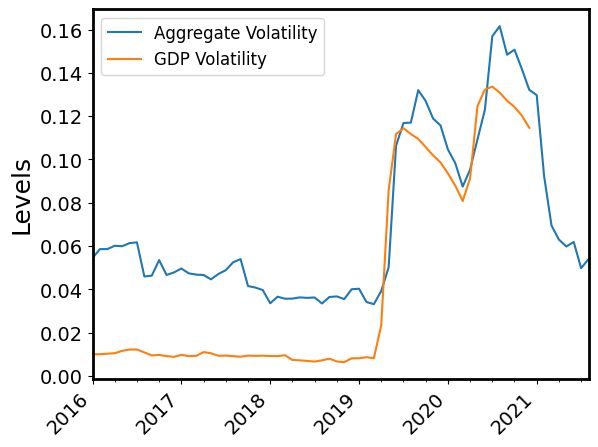

In [72]:
cs_agg_growth_68_months_df[0].plot( label='Aggregate Volatility')
cs_GDP_growth_time_series_seas_pluto_time_df[0].plot( label='GDP Volatility')


# Add labels and title
plt.ylabel('Levels',fontsize = 18)
plt.xlabel('',fontsize = 18)

# Increase the linewidth of the axes lines
ax = plt.gca()  # Get the current Axes instance
for spine in ax.spines.values():
    spine.set_linewidth(2)
    
# Increase the size of x-axis ticks
plt.xticks(fontsize=14)

# Increase the size of y-axis ticks
plt.yticks(fontsize=14)
plt.legend(fontsize = 12)
plt.xticks(rotation=45, ha='right')

plt.savefig('plots/vol_GDP_payment_compare.png',bbox_inches='tight')



plt.show()